# Import Libraries

The below block imports all needed libraries. Feel free to add additional libraries that you need and rerun below block.

Two last lines inform you of the Pytorch version and the availability of GPU.
The last line should print `GPU availability: True`.

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision.transforms as transforms

print('Pytorch version: ', torch.__version__)
print('GPU availability: ', torch.cuda.is_available())

Pytorch version:  2.0.1+cu118
GPU availability:  True


# Download Dataset
If you are familiar with Linux bash scripts, you can put `!` at the beginning of a command to order Colab of interpreting it as bash scripts instead of python scripts.

The below block downloads MNIST dataset and decompresses it.

In [ ]:
!wget https://github.com/myleott/mnist_png/raw/master/mnist_png.tar.gz
!tar xzf mnist_png.tar.gz

--2023-10-03 20:16:51--  https://github.com/myleott/mnist_png/raw/master/mnist_png.tar.gz
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/myleott/mnist_png/master/mnist_png.tar.gz [following]
--2023-10-03 20:16:52--  https://raw.githubusercontent.com/myleott/mnist_png/master/mnist_png.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15683414 (15M) [application/octet-stream]
Saving to: ‘mnist_png.tar.gz’

mnist_png.tar.gz    100%[===================>]  14.96M  41.5MB/s    in 0.4s    

2023-10-03 20:16:54 (41.5 MB/s) - ‘mnist_png.tar.gz’ saved [15683414/15683414]



# Define Dataset Class

In order to use a dataset, we need to design a pytorch Dataset Class to process it.
In the block below, you are required to complete:

* TODO1: `def __init__(root, transform)` function to build the MNIST dataset from images included in the `root` directory. Please add code below `TODO1` to complete this function. The dataset should be captured by two lists, i.e., `self.images` that contains all images of MNIST, and `self.labels` that contains the corresponding label of each image in `self.images`.
* TODO2: `def __getitem__(index)` to draw a sample at `index` and its corresponding label. This function should return a tuple (X, y), where X is the image (numpy ndarray of shape 1x28x28) and y is a scalar from 0 to 9 representing X's label.

In [ ]:
# Define Dataset:
class MNISTDataset(Dataset):
    def __init__(self, root, transform=None):
        # `root` is expected to contain 10 sub-directories, each of which is named after the label of all images included inside.
        # transform is a Torchvision.Transforms object that pre-processes an image
        self.root = root
        self.transform = transform
        #TODO 1: Read dataset.
        # All images should be contained in a list `self.images`, and their corresponding labels in a list `self.labels`
        # `self.images[i]` should contain a numpy ndarrays of size 1x28x28.
        # `self.labels[i]` should contain a single integer of [0-9] representing the label of `self.images[i]`.
        labels = os.listdir(root)
        self.labels = []
        self.images = []
        for l in labels:
            img_files = os.listdir(os.path.join(root, l))
            for img_file in img_files:
                img_file = os.path.join(root, l, img_file)
                img = plt.imread(img_file)
                self.images.append(img)
                self.labels.append(int(l))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # TODO2: retrieve `self.images[index]` and feed the image into self.transform.
        # Then, return a tuple (X, y), where X is the image and y is its label.
        image = self.images[index]
        #image = self.transform(image)#transfor = self.transform(image)
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def show_random(self):
        indices = np.random.randint(0, len(self), [16,])
        f, ax = plt.subplots(4, 4, figsize=(10, 10))
        for i in range(4):
            for j in range(4):
                ax[i, j].imshow(self.images[indices[i * 4 + j]])
                ax[i, j].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
                ax[i, j].set_title(f'Label: {self.labels[indices[i * 4 + j]]}')
        plt.show()

# Define Model Class
Below, we define a simple Multi-layer Perceptron Network with a hidden layer.
A pytorch model necessarily have two functions, i.e., `__init__`, which defines all layers of the network, and `forward`, which is fed the input data and processes through all layers defined in `__init__`.

In [ ]:
# Define Network:
class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28) # Flatten every image into a single vector
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def name(self):
        return "MLP"

# Create MNISTDataset objects and dataloaders
Below, we create the objects to process training and testing sets of MNIST data.
As there are no held-out validation set, we manually split the training set into training and validation subsets with the ratio of 8:2.

After creating dataset objects, we wrap them by a Pytorch Dataloader to allow several necessary features in training deep learning models, e.g., mini-batch feeding, shuffling.

***Note***: if you successfully complete `__init__` function of `MNISTDataset`, its `show_random` function would successfully randomly show 16 images and corresponding labels in the dataset.

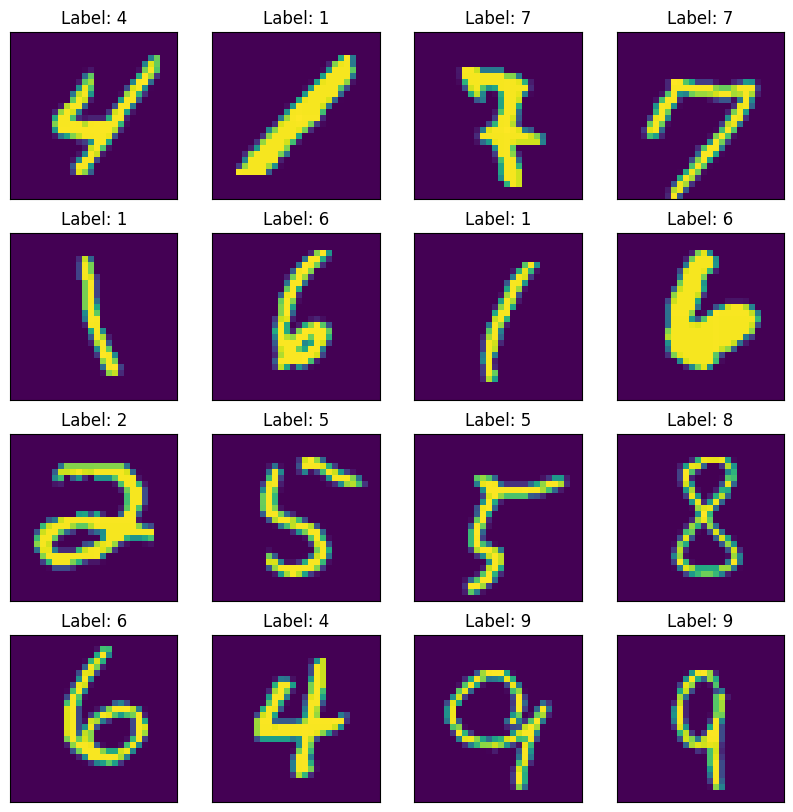

Training set size:  48000
Validation set size:  12000
Testing set size:  10000


In [ ]:
################################################################
# Hyper parameters
################################################################
BATCH_SIZE = 128
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

################################################################
# Create training and testing dataset and show random examples
################################################################
trainval_set = MNISTDataset('mnist_png/training', transform=transform)
trainval_set.show_random()

test_set = MNISTDataset('mnist_png/testing', transform=transform)

################################################################
# As there is no validation set
# We split training dataset into training and validation sets
################################################################
train_size = int(0.8 * len(trainval_set))
val_size = len(trainval_set) - train_size
train_set, val_set = torch.utils.data.random_split(
    dataset=trainval_set,
    lengths=[train_size, val_size],
    generator=torch.Generator().manual_seed(42))

################################################################
# Print lengths of subsets
################################################################
print('Training set size: ', len(train_set))
print('Validation set size: ', len(val_set))
print('Testing set size: ', len(test_set))

################################################################
# Print lengths of subsets
################################################################
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=BATCH_SIZE,
    shuffle=False)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=BATCH_SIZE,
    shuffle=False)

# Create Model and Training Process

In the below block, we create an object (our model) from the MLPNet deep neural network defined above.

Then, we create the `criterion` that will compute a loss value from predictions genereated by our model and groundtruth labels. We also create the `optimizer`, which updates our model's learnable parameters based on the loss value to improve its performance.

Finally, we start training the model through `EPOCHS` number of epochs. At each epoch, after training the model through the training subset, we evaluate its loss and accuracy on validation subset. Usually, we would base on the loss or accuracy on validation subset to pick out the best performed model during our training process.

Your tasks:


*   TODO 3: Based on average accuracy on validation set, save the model weights into a file. Hint: use `torch.save(model.state_dict(), PATH)` to save model weights into a file specified by `PATH`.
*   TODO 4: Load the best model weights saved in `PATH` from above task into our `model`. Then, compute loss and accuracy of the best model on testing subset. Hint: use `checkpoint = torch.load(PATH)` to load content of file specified in `PATH` into `checkpoint`, then, use `model.load_state_dict(checkpoint)` to load parameters saved in `checkpoint` into `model`.




In [ ]:
################################################################
# Hyper parameters
################################################################
LR = 0.001 # learning rate
EPOCHS = 100 # number of epochs to train model

################################################################
# Create model
################################################################
model = MLPNet().cuda()

################################################################
# Create optimizer and criterion
################################################################
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
criterion = nn.CrossEntropyLoss()

################################################################
# Training process
################################################################
for epoch in range(EPOCHS):
    # trainning
    total_loss = 0
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = x.cuda(), target.cuda()
        out = model(x)
        loss = criterion(out, target)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(train_set)
    print(f'==>>> epoch: {epoch}, train loss: {avg_loss:.6f}')

    # evaluating
    correct_cnt, total_loss = 0, 0
    for batch_idx, (x, target) in enumerate(val_loader):
        x, target = x.cuda(), target.cuda()
        out = model(x)
        _, pred_label = torch.max(out, 1)
        correct_cnt += (pred_label == target).sum()
        # smooth average
        total_loss += loss.item()
    avg_loss = total_loss / len(val_set)
    avg_acc = correct_cnt / len(val_set)
    print(f'==>>> epoch: {epoch}, val loss: {avg_loss:.6f}, val accuracy: {avg_acc:.6f}')
    # TODO3: Based on average accuracy on validation set, save the model weights into a file
    torch.save(model.state_dict(), '/content/model.pt')
################################################################
# Testing process
################################################################
# TODO4: use best performed model from the above process to compute loss and accuracy on testing set.
checkpoint = torch.load('/content/model.pt')
model.load_state_dict(checkpoint)

==>>> epoch: 0, train loss: 0.016876
==>>> epoch: 0, val loss: 0.014884, val accuracy: 0.629083
==>>> epoch: 1, train loss: 0.010452
==>>> epoch: 1, val loss: 0.006955, val accuracy: 0.817917
==>>> epoch: 2, train loss: 0.005341
==>>> epoch: 2, val loss: 0.004906, val accuracy: 0.860000
==>>> epoch: 3, train loss: 0.003926
==>>> epoch: 3, val loss: 0.003096, val accuracy: 0.876833
==>>> epoch: 4, train loss: 0.003385
==>>> epoch: 4, val loss: 0.004172, val accuracy: 0.887083
==>>> epoch: 5, train loss: 0.003087
==>>> epoch: 5, val loss: 0.002875, val accuracy: 0.894500
==>>> epoch: 6, train loss: 0.002890
==>>> epoch: 6, val loss: 0.003184, val accuracy: 0.901667
==>>> epoch: 7, train loss: 0.002752
==>>> epoch: 7, val loss: 0.002455, val accuracy: 0.902917
==>>> epoch: 8, train loss: 0.002638
==>>> epoch: 8, val loss: 0.002466, val accuracy: 0.908750
==>>> epoch: 9, train loss: 0.002549
==>>> epoch: 9, val loss: 0.002003, val accuracy: 0.910583
==>>> epoch: 10, train loss: 0.002467
==

<All keys matched successfully>

# Training Famous State-of-the-art Neural Network on MNIST


In the next three blocks, you are requested to find the pytorch implementations for three famous state-of-the-art networks (i.e., LeNet, VGG16, and ResNet18) and train them using the training process similar to the above block.

Thes tasks will help you have a comparisons between state-of-the-arts. Your specific tasks are:



*   TODO 5: Define LeNet network and train them using Cross Entropy loss, SGD optimizer, learning rate of 0.001, and in 100 epochs. Saving best performed model on validation subset during training process, and finally evaluate its performance (loss, accuracy) on testing set.

*   TODO 6: Define VGG16 network and train them using Cross Entropy loss, SGD optimizer, learning rate of 0.001, and in 100 epochs. Saving best performed model on validation subset during training process, and finally evaluate its performance (loss, accuracy) on testing set.

*  TODO 7: Define ResNet18 network and train them using Cross Entropy loss, SGD optimizer, learning rate of 0.001, and in 100 epochs. Saving best performed model on validation subset during training process, and finally evaluate its performance (loss, accuracy) on testing set.











In [ ]:
# TODO5: Define LeNet network and train it using above training and testing processes
#transform.pad(2,2)

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# From local helper files
#from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
#from helper_train import train_model
#from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
#from helper_dataset import get_dataloaders_mnist


RANDOM_SEED = 123
BATCH_SIZE = 128
NUM_EPOCHS = 100
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#set_all_seeds(RANDOM_SEED)

In [ ]:
import torch.nn as nn
import torch.nn.functional as func

class lenet(nn.Module):
    '''
    input: 3x32x32 image
    output: 10 class probability
    '''
    def __init__(self):
        super(lenet, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5) #c1:featuremaps 6@28x28 #output = (input-filter)/stride + 1, #filter:5size
        self.conv2 = nn.Conv2d(6,16,5) #c3:feature_maps 16@10x10
        self.maxPool = nn.MaxPool2d(2,2) #subsampling 1/2size
        self.fc1 = nn.Linear(16*5*5,120) #f5:layer120
        self.fc2 = nn.Linear(120,84) #f6:layer84
        self.fc3 = nn.Linear(84,10) #output:10 class

    def forward(self,x):
        x = self.maxPool(func.relu(self.conv1(x)))
        x = self.maxPool(func.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5) #flattens #tensor 형태 변환, 일렬로 16*5*5형태로 만듦
        x = func.relu(self.fc1(x))
        x = func.relu(self.fc2(x))
        x = self.fc3(x)
        return x

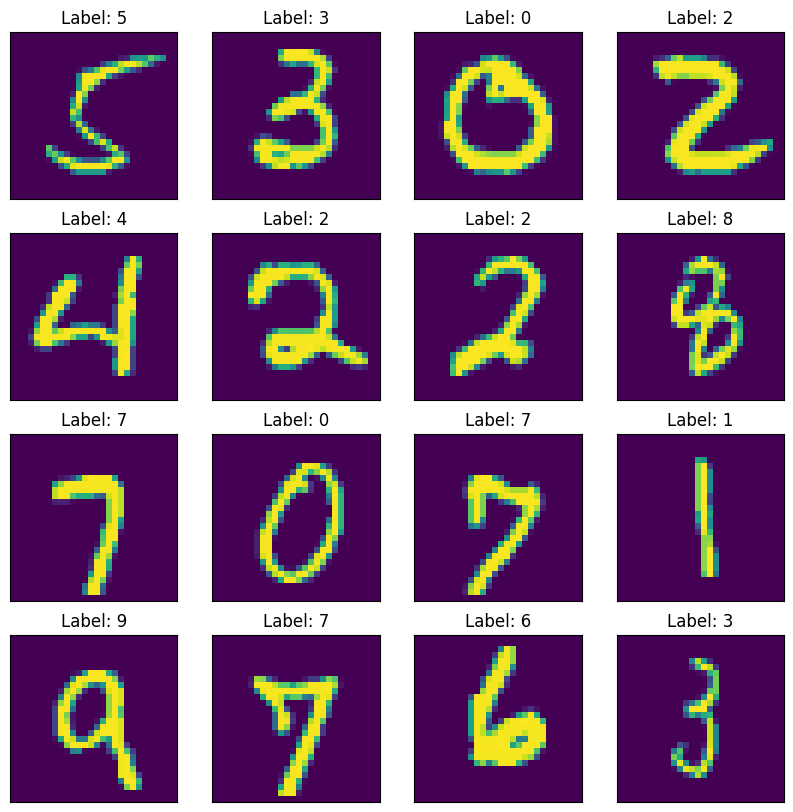

Training set size:  48000
Validation set size:  12000
Testing set size:  10000


In [ ]:
################################################################
# Hyper parameters
################################################################
BATCH_SIZE = 128
transform = transforms.Compose([transforms.ToTensor(),transforms.Lambda(lambda x: x.repeat(3,1,1)),torchvision.transforms.Pad(padding=2, fill=0), transforms.Normalize((0.5,), (1.0,))])

################################################################
# Create training and testing dataset and show random examples
################################################################
trainval_set = MNISTDataset('mnist_png/training', transform=transform)
trainval_set.show_random()

test_set = MNISTDataset('mnist_png/testing', transform=transform)

################################################################
# As there is no validation set
# We split training dataset into training and validation sets
################################################################
train_size = int(0.8 * len(trainval_set))
val_size = len(trainval_set) - train_size
train_set, val_set = torch.utils.data.random_split(
    dataset=trainval_set,
    lengths=[train_size, val_size],
    generator=torch.Generator().manual_seed(42))

################################################################
# Print lengths of subsets
################################################################
print('Training set size: ', len(train_set))
print('Validation set size: ', len(val_set))
print('Testing set size: ', len(test_set))

################################################################
# Print lengths of subsets
################################################################
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=BATCH_SIZE,
    shuffle=False)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=BATCH_SIZE,
    shuffle=False)

In [ ]:
################################################################
# Hyper parameters
################################################################
LR = 0.001 # learning rate
EPOCHS = 100 # number of epochs to train model

################################################################
# Create model
################################################################
model = lenet().cuda()

################################################################
# Create optimizer and criterion
################################################################
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
criterion = nn.CrossEntropyLoss()

################################################################
# Training process
################################################################
for epoch in range(EPOCHS):
    # trainning
    total_loss = 0
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = x.cuda(), target.cuda()
        out = model(x)
        loss = criterion(out, target)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(train_set)
    print(f'==>>> epoch: {epoch}, train loss: {avg_loss:.6f}')

    # evaluating
    correct_cnt, total_loss = 0, 0
    for batch_idx, (x, target) in enumerate(val_loader):
        x, target = x.cuda(), target.cuda()
        out = model(x)
        _, pred_label = torch.max(out, 1)
        correct_cnt += (pred_label == target).sum()
        # smooth average
        total_loss += loss.item()
    avg_loss = total_loss / len(val_set)
    avg_acc = correct_cnt / len(val_set)
    print(f'==>>> epoch: {epoch}, val loss: {avg_loss:.6f}, val accuracy: {avg_acc:.6f}')
    # TODO3: Based on average accuracy on validation set, save the model weights into a file
    torch.save(model.state_dict(), '/content/model.pt')
################################################################
# Testing process
################################################################
# TODO4: use best performed model from the above process to compute loss and accuracy on testing set.
checkpoint = torch.load('/content/model.pt')
model.load_state_dict(checkpoint)

==>>> epoch: 0, train loss: 0.017966
==>>> epoch: 0, val loss: 0.018020, val accuracy: 0.168000
==>>> epoch: 1, train loss: 0.017888
==>>> epoch: 1, val loss: 0.017925, val accuracy: 0.195750
==>>> epoch: 2, train loss: 0.017420
==>>> epoch: 2, val loss: 0.016351, val accuracy: 0.606000
==>>> epoch: 3, train loss: 0.008248
==>>> epoch: 3, val loss: 0.003648, val accuracy: 0.867083
==>>> epoch: 4, train loss: 0.002875
==>>> epoch: 4, val loss: 0.002788, val accuracy: 0.915833
==>>> epoch: 5, train loss: 0.002032
==>>> epoch: 5, val loss: 0.001401, val accuracy: 0.935500
==>>> epoch: 6, train loss: 0.001572
==>>> epoch: 6, val loss: 0.000988, val accuracy: 0.945167
==>>> epoch: 7, train loss: 0.001287
==>>> epoch: 7, val loss: 0.001175, val accuracy: 0.955083
==>>> epoch: 8, train loss: 0.001096
==>>> epoch: 8, val loss: 0.000714, val accuracy: 0.959917
==>>> epoch: 9, train loss: 0.000955
==>>> epoch: 9, val loss: 0.000902, val accuracy: 0.964000
==>>> epoch: 10, train loss: 0.000857
==

<All keys matched successfully>

In [ ]:
# TODO6: Define VGG16 network and train it using above training and testing processes
import torch.nn as nn
import torch.nn.functional as func
import math

class vggnet(nn.Module):
    '''
    input: 3x32x32 image
    output: 10 class probability
    '''
    def __init__(self, features):
        super(vggnet, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 1 * 1, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10)
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        # print(sum(x[0, :]).detach().numpy()[0, 0],
        #       sum(x[1, :]).detach().numpy()[0, 0],
        #       sum(x[2, :]).detach().numpy()[0, 0],
        #       sum(x[3, :]).detach().numpy()[0, 0])
        x = x.view(-1, 512*1*1) #x = x.view(-1, x.size(0))
        x = self.classifier(x)
        # print(sum(x[0, :]).detach().numpy(),
        #       sum(x[1, :]).detach().numpy(),
        #       sum(x[2, :]).detach().numpy(),
        #       sum(x[3, :]).detach().numpy())
        return x

def make_layers(cfg):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            if (v==257) or (v ==513):
                conv2d = nn.Conv2d(in_channels, v-1, kernel_size=1)
                in_channels = v-1
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                in_channels = v
            layers += [conv2d, nn.ReLU(inplace=True)]

    return nn.Sequential(*layers)

cfgs = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'C': [64, 64, 'M', 128, 128, 'M', 256, 256, 257, 'M', 512, 512, 513, 'M', 512, 512, 513, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
}

def vgg11(): # configuration A
    return vggnet(make_layers(cfgs['A']))

def vgg13(): # configuration B
    return vggnet(make_layers(cfgs['B']))

def vgg16_1(): # configuration C
    return vggnet(make_layers(cfgs['C']))

def vgg16(): # configuration D
    return vggnet(make_layers(cfgs['D']))

def vgg19(): # configuration E
    return vggnet(make_layers(cfgs['E']))

In [ ]:
from collections import OrderedDict
class VGG(nn.Module):
    """
    Standard PyTorch implementation of VGG. Pretrained imagenet model is used.
    """
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            # conv1
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),

            # conv2
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),

            # conv3
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),

            # conv4
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),

            # conv5
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 1000)
        )

        # We need these for MaxUnpool operation
        self.conv_layer_indices = [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]
        self.feature_maps = OrderedDict()
        self.pool_locs = OrderedDict()

    def forward(self, x):
        for layer in self.features:
            if isinstance(layer, nn.MaxPool2d):
                x, location = layer(x)
            else:
                x = layer(x)

        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x


def get_vgg():
    vgg = VGG()
    temp = torchvision.models.vgg16(pretrained=True)
    vgg.load_state_dict(temp.state_dict())
    return vgg

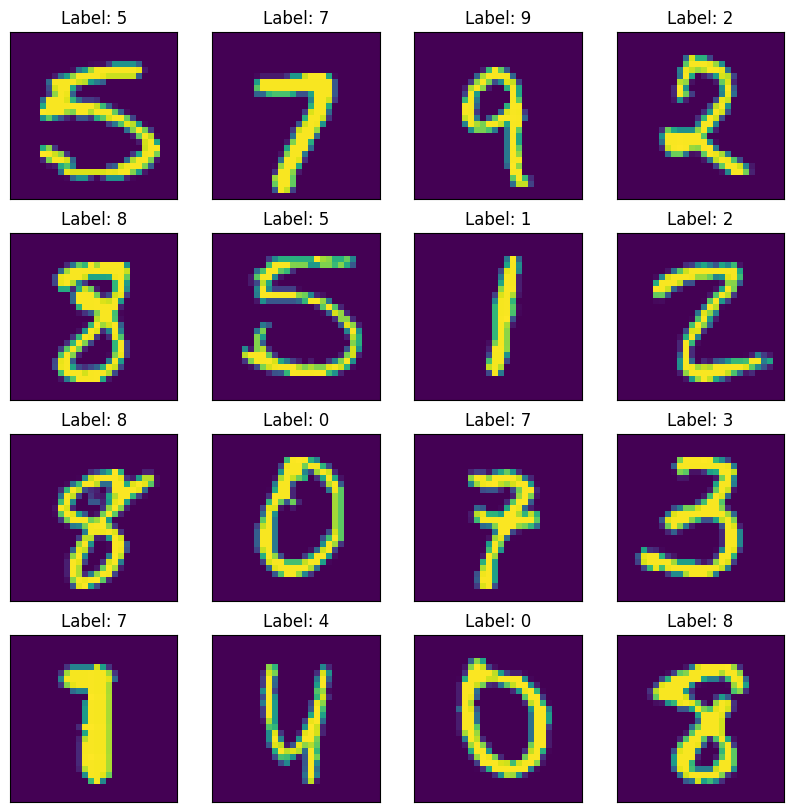

Training set size:  48000
Validation set size:  12000
Testing set size:  10000


In [ ]:
################################################################
# Hyper parameters
################################################################
BATCH_SIZE = 128
transform = transforms.Compose([transforms.ToTensor(),transforms.Lambda(lambda x: x.repeat(3,1,1)),torchvision.transforms.Pad(padding=2, fill=0), transforms.Normalize((0.5,), (1.0,))])

################################################################
# Create training and testing dataset and show random examples
################################################################
trainval_set = MNISTDataset('mnist_png/training', transform=transform)
trainval_set.show_random()

test_set = MNISTDataset('mnist_png/testing', transform=transform)

################################################################
# As there is no validation set
# We split training dataset into training and validation sets
################################################################
train_size = int(0.8 * len(trainval_set))
val_size = len(trainval_set) - train_size
train_set, val_set = torch.utils.data.random_split(
    dataset=trainval_set,
    lengths=[train_size, val_size],
    generator=torch.Generator().manual_seed(42))

################################################################
# Print lengths of subsets
################################################################
print('Training set size: ', len(train_set))
print('Validation set size: ', len(val_set))
print('Testing set size: ', len(test_set))

################################################################
# Print lengths of subsets
################################################################
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=BATCH_SIZE,
    shuffle=False)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=BATCH_SIZE,
    shuffle=False)

In [ ]:
################################################################
# Hyper parameters
################################################################
LR = 0.001 # learning rate
EPOCHS = 100 # number of epochs to train model

################################################################
# Create model
################################################################
model = torchvision.models.vgg16().cuda()

################################################################
# Create optimizer and criterion
################################################################
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
criterion = nn.CrossEntropyLoss()

################################################################
# Training process
################################################################
for epoch in range(EPOCHS):
    # trainning
    total_loss = 0
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = x.cuda(), target.cuda()
        out = model(x)
        loss = criterion(out, target)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(train_set)
    print(f'==>>> epoch: {epoch}, train loss: {avg_loss:.6f}')

    # evaluating
    correct_cnt, total_loss = 0, 0
    for batch_idx, (x, target) in enumerate(val_loader):
        x, target = x.cuda(), target.cuda()
        out = model(x)
        _, pred_label = torch.max(out, 1)
        correct_cnt += (pred_label == target).sum()
        # smooth average
        total_loss += loss.item()
    avg_loss = total_loss / len(val_set)
    avg_acc = correct_cnt / len(val_set)
    print(f'==>>> epoch: {epoch}, val loss: {avg_loss:.6f}, val accuracy: {avg_acc:.6f}')
    # TODO3: Based on average accuracy on validation set, save the model weights into a file
    torch.save(model.state_dict(), '/content/model.pt')
################################################################
# Testing process
################################################################
# TODO4: use best performed model from the above process to compute loss and accuracy on testing set.
checkpoint = torch.load('/content/model.pt')
model.load_state_dict(checkpoint)

==>>> epoch: 0, train loss: 0.022809
==>>> epoch: 0, val loss: 0.018390, val accuracy: 0.112667
==>>> epoch: 1, train loss: 0.016093
==>>> epoch: 1, val loss: 0.007291, val accuracy: 0.619167
==>>> epoch: 2, train loss: 0.003118
==>>> epoch: 2, val loss: 0.001210, val accuracy: 0.949500
==>>> epoch: 3, train loss: 0.001029
==>>> epoch: 3, val loss: 0.001079, val accuracy: 0.964750
==>>> epoch: 4, train loss: 0.000678
==>>> epoch: 4, val loss: 0.000557, val accuracy: 0.976000
==>>> epoch: 5, train loss: 0.000520
==>>> epoch: 5, val loss: 0.000293, val accuracy: 0.977250
==>>> epoch: 6, train loss: 0.000423
==>>> epoch: 6, val loss: 0.000228, val accuracy: 0.980917
==>>> epoch: 7, train loss: 0.000346
==>>> epoch: 7, val loss: 0.000327, val accuracy: 0.980167
==>>> epoch: 8, train loss: 0.000290
==>>> epoch: 8, val loss: 0.000331, val accuracy: 0.981083
==>>> epoch: 9, train loss: 0.000255
==>>> epoch: 9, val loss: 0.000035, val accuracy: 0.985083
==>>> epoch: 10, train loss: 0.000227
==

<All keys matched successfully>

In [ ]:
# TODO7: Define Resnet18 network and train it using above training and testing processes
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)
class ResNet18(nn.Module):
    def __init__(self, in_channels, resblock, outputs=1000):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False)
        )

        self.layer2 = nn.Sequential(
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=False)
        )

        self.layer3 = nn.Sequential(
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False)
        )


        self.layer4 = nn.Sequential(
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False)
        )

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(512, outputs)

    def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.gap(input)
        input = torch.flatten(input)
        input = self.fc(input)

        return input

In [ ]:
import torch
import torch.nn as nn


class Block(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        assert num_layers in [18, 34, 50, 101, 152], "should be a a valid architecture"
        super(Block, self).__init__()
        self.num_layers = num_layers
        if self.num_layers > 34:
            self.expansion = 4
        else:
            self.expansion = 1
        # ResNet50, 101, and 152 include additional layer of 1x1 kernels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        if self.num_layers > 34:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        if self.num_layers > 34:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)


def ResNet18(img_channels=3, num_classes=1000):
    return ResNet(18, Block, img_channels, num_classes)


def ResNet34(img_channels=3, num_classes=1000):
    return ResNet(34, Block, img_channels, num_classes)


def ResNet50(img_channels=3, num_classes=1000):
    return ResNet(50, Block, img_channels, num_classes)


def ResNet101(img_channels=3, num_classes=1000):
    return ResNet(101, Block, img_channels, num_classes)


def ResNet152(img_channels=3, num_classes=1000):
    return ResNet(152, Block, img_channels, num_classes)


def test():
    net = ResNet18(img_channels=3, num_classes=1000)
    y = net(torch.randn(4, 3, 224, 224)).to("cuda")
    print(y.size())


test()

torch.Size([4, 1000])


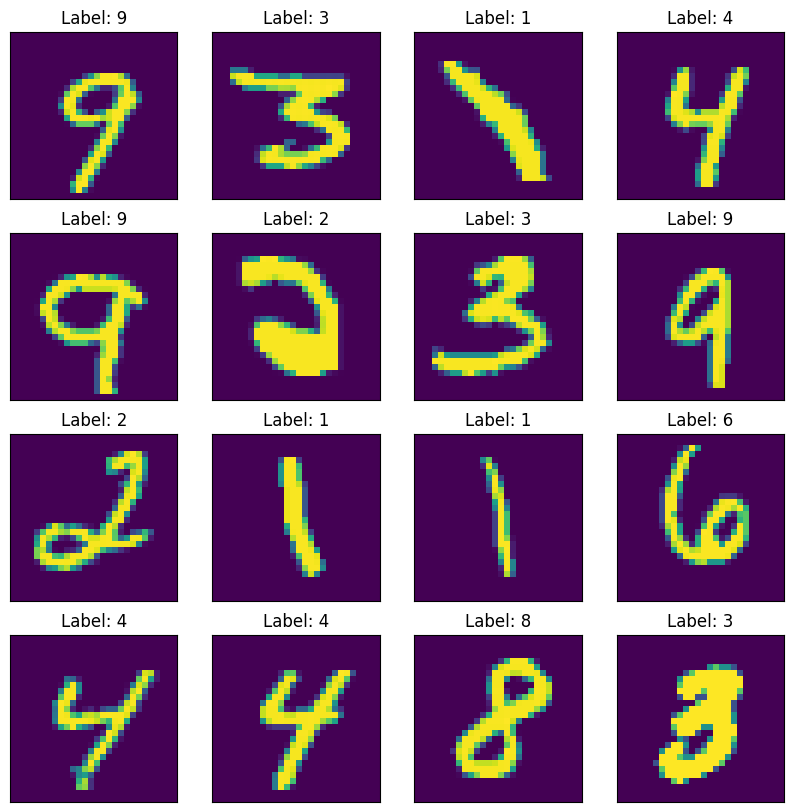

Training set size:  48000
Validation set size:  12000
Testing set size:  10000


In [ ]:
################################################################
# Hyper parameters
################################################################
BATCH_SIZE = 128
transform = transforms.Compose([transforms.ToTensor(),transforms.Lambda(lambda x: x.repeat(3,1,1)),torchvision.transforms.Pad(padding=2, fill=0), transforms.Normalize((0.5,), (1.0,))])

################################################################
# Create training and testing dataset and show random examples
################################################################
trainval_set = MNISTDataset('mnist_png/training', transform=transform)
trainval_set.show_random()

test_set = MNISTDataset('mnist_png/testing', transform=transform)

################################################################
# As there is no validation set
# We split training dataset into training and validation sets
################################################################
train_size = int(0.8 * len(trainval_set))
val_size = len(trainval_set) - train_size
train_set, val_set = torch.utils.data.random_split(
    dataset=trainval_set,
    lengths=[train_size, val_size],
    generator=torch.Generator().manual_seed(42))

################################################################
# Print lengths of subsets
################################################################
print('Training set size: ', len(train_set))
print('Validation set size: ', len(val_set))
print('Testing set size: ', len(test_set))

################################################################
# Print lengths of subsets
################################################################
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=BATCH_SIZE,
    shuffle=False)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=BATCH_SIZE,
    shuffle=False)

In [ ]:
################################################################
# Hyper parameters
################################################################
LR = 0.001 # learning rate
EPOCHS = 100 # number of epochs to train model

################################################################
# Create model
################################################################
model =  ResNet18().cuda()

################################################################
# Create optimizer and criterion
################################################################
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
criterion = nn.CrossEntropyLoss()

################################################################
# Training process
################################################################
for epoch in range(EPOCHS):
    # trainning
    total_loss = 0
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = x.cuda(), target.cuda()
        out = model(x)
        loss = criterion(out, target)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(train_set)
    print(f'==>>> epoch: {epoch}, train loss: {avg_loss:.6f}')

    # evaluating
    correct_cnt, total_loss = 0, 0
    for batch_idx, (x, target) in enumerate(val_loader):
        x, target = x.cuda(), target.cuda()
        out = model(x)
        _, pred_label = torch.max(out, 1)
        correct_cnt += (pred_label == target).sum()
        # smooth average
        total_loss += loss.item()
    avg_loss = total_loss / len(val_set)
    avg_acc = correct_cnt / len(val_set)
    print(f'==>>> epoch: {epoch}, val loss: {avg_loss:.6f}, val accuracy: {avg_acc:.6f}')
    # TODO3: Based on average accuracy on validation set, save the model weights into a file
    torch.save(model.state_dict(), '/content/model.pt')
################################################################
# Testing process
################################################################
# TODO4: use best performed model from the above process to compute loss and accuracy on testing set.
checkpoint = torch.load('/content/model.pt')
model.load_state_dict(checkpoint)

==>>> epoch: 0, train loss: 0.002733
==>>> epoch: 0, val loss: 0.000307, val accuracy: 0.981000
==>>> epoch: 1, train loss: 0.000317
==>>> epoch: 1, val loss: 0.000388, val accuracy: 0.983167
==>>> epoch: 2, train loss: 0.000164
==>>> epoch: 2, val loss: 0.000367, val accuracy: 0.984750
==>>> epoch: 3, train loss: 0.000077
==>>> epoch: 3, val loss: 0.000051, val accuracy: 0.985417
==>>> epoch: 4, train loss: 0.000046
==>>> epoch: 4, val loss: 0.000042, val accuracy: 0.987667
==>>> epoch: 5, train loss: 0.000027
==>>> epoch: 5, val loss: 0.000013, val accuracy: 0.987000
==>>> epoch: 6, train loss: 0.000018
==>>> epoch: 6, val loss: 0.000008, val accuracy: 0.987750
==>>> epoch: 7, train loss: 0.000012
==>>> epoch: 7, val loss: 0.000011, val accuracy: 0.988083
==>>> epoch: 8, train loss: 0.000010
==>>> epoch: 8, val loss: 0.000004, val accuracy: 0.987583
==>>> epoch: 9, train loss: 0.000007
==>>> epoch: 9, val loss: 0.000001, val accuracy: 0.988417
==>>> epoch: 10, train loss: 0.000007
==

<All keys matched successfully>